### Using convnets with small datasets

In [1]:
# Most Important 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import os
import shutil, tarfile, glob
from pathlib import Path
from PIL import Image

### Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

### If you use Kaggle API
Download the data from kaggle to colab using Kaggle API
https://www.kaggle.com/general/74235

``` bash
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c dogs-vs-cats
!unzip /content/dogs-vs-cats.zip
```

In [2]:
## I downlaod the data to my pc

original_dir = 'full_kaggle_dataset_dogs_cats'
base_dir = 'catss_dogs_dataset'

# check for directory
if not os.path.isdir(base_dir):
    os.makedirs(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# check for directory
if not os.path.isdir(train_dir):
    os.makedirs(train_dir)
# check for directory
if not os.path.isdir(valid_dir):
    os.makedirs(valid_dir)
# check for directory
if not os.path.isdir(test_dir):
    os.makedirs(test_dir)
    
# check for directory
if not os.path.isdir(train_cats_dir):
    os.makedirs(train_cats_dir)
# check for directory
if not os.path.isdir(train_dogs_dir):
    os.makedirs(train_dogs_dir)
# check for directory
if not os.path.isdir(valid_cats_dir):
    os.makedirs(valid_cats_dir)
# check for directory
if not os.path.isdir(valid_dogs_dir):
    os.makedirs(valid_dogs_dir)
# check for directory
if not os.path.isdir(test_cats_dir):
    os.makedirs(test_cats_dir)
# check for directory
if not os.path.isdir(test_dogs_dir):
    os.makedirs(test_dogs_dir)
    
    
# Copy first 1000 cat images to train_cats_dir
imgs_train = ['cat.{}.jpg'.format(i) for i in range(1000)]
for img in imgs_train:
    src = os.path.join(original_dir, img)
    dst = os.path.join(train_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy first 1000 dog images to train_dogs_dir
imgs_train = ['dog.{}.jpg'.format(i) for i in range(1000)]
for img in imgs_train:
    src = os.path.join(original_dir, img)
    dst = os.path.join(train_dogs_dir, img)
    shutil.copyfile(src, dst)
    
# Copy second 500 cat images to valid_cats_dir
imgs_valid = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for img in imgs_valid:
    src = os.path.join(original_dir, img)
    dst = os.path.join(valid_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy second 500 dog images to valid_dogs_dir
imgs_valid = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for img in imgs_valid:
    src = os.path.join(original_dir, img)
    dst = os.path.join(valid_dogs_dir, img)
    shutil.copyfile(src, dst)
    
# Copy second 500 cat images to test_cats_dir
imgs_test = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for img in imgs_test:
    src = os.path.join(original_dir, img)
    dst = os.path.join(test_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy second 500 dog images to test_dogs_dir
imgs_test = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for img in imgs_test:
    src = os.path.join(original_dir, img)
    dst = os.path.join(test_dogs_dir, img)
    shutil.copyfile(src, dst)    ## data is ready

In [3]:
## check
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(valid_cats_dir)))
print('total validation dog images:', len(os.listdir(valid_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


##### you can mount google drive if you are using colab
``` python
from google.colab import drive
drive.mount('/content/gdrive')
```

In [4]:
## show some images
train_cats = Path(train_cats_dir)

## read these all training images paths as Series
train_cats_paths = pd.Series(sorted(list(train_cats.glob(r'*.jpg'))), name='Filepath').astype(str)

train_cats_paths.head()

0      cats_dogs_dataset\train\cats\cat.0.jpg
1      cats_dogs_dataset\train\cats\cat.1.jpg
2     cats_dogs_dataset\train\cats\cat.10.jpg
3    cats_dogs_dataset\train\cats\cat.100.jpg
4    cats_dogs_dataset\train\cats\cat.101.jpg
Name: Filepath, dtype: object

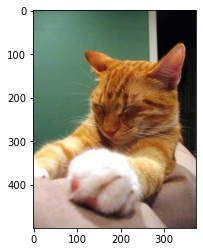

In [5]:
## show image
img_cat = plt.imread(train_cats_paths[50])

plt.imshow(img_cat);  ## images have diffrent sizes

### Data Preprocessing without Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## create the generators
train_gen = train_datagen.flow_from_directory(directory=train_dir, 
                                              target_size=(150, 150), class_mode='binary', 
                                              color_mode='rgb',  batch_size=20, 
                                              shuffle=True, seed=123)

valid_gen = train_datagen.flow_from_directory(directory=valid_dir, 
                                              target_size=(150, 150), class_mode='binary', 
                                              color_mode='rgb',  batch_size=20, 
                                              shuffle=False, seed=123)

test_gen = test_datagen.flow_from_directory(directory=test_dir, 
                                              target_size=(150, 150), class_mode='binary',
                                              color_mode='rgb',  batch_size=20, 
                                              shuffle=False, seed=123)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Note : Here --> we are not using Data Augmentation, so you should adjust carefully the parameters when fitting , becuase generator still loop even the dataset is finsished

#### Build the Model

In [8]:
model = tf.keras.models.Sequential([
    ## conv base
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    ## top classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


## Prepare the Hyperparameters
## complile the Model
model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
                      metrics=['accuracy'])

early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_gen, validation_data=(valid_gen), 
                    steps_per_epoch=100, validation_steps=50, epochs=20, batch_size=20)
   
## steps_per_epoch=train_size/batch_size
## validation_steps=valid_size/batch_size

Epoch 1/20
100/100 [==============================] - 11s 86ms/step - loss: 0.6925 - accuracy: 0.5215 - val_loss: 0.6757 - val_accuracy: 0.5320
Epoch 2/20
100/100 [==============================] - 9s 87ms/step - loss: 0.6527 - accuracy: 0.6195 - val_loss: 0.6356 - val_accuracy: 0.6500
Epoch 3/20
100/100 [==============================] - 9s 88ms/step - loss: 0.6104 - accuracy: 0.6615 - val_loss: 0.6061 - val_accuracy: 0.6590
Epoch 4/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5679 - accuracy: 0.7035 - val_loss: 0.6436 - val_accuracy: 0.6400
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.5475 - accuracy: 0.7185 - val_loss: 0.5880 - val_accuracy: 0.6800
Epoch 6/20
100/100 [==============================] - 9s 87ms/step - loss: 0.5249 - accuracy: 0.7340 - val_loss: 0.5985 - val_accuracy: 0.6800
Epoch 7/20
100/100 [==============================] - 9s 85ms/step - loss: 0.5024 - accuracy: 0.7505 - val_loss: 0.5775 - val_accuracy: 0.692

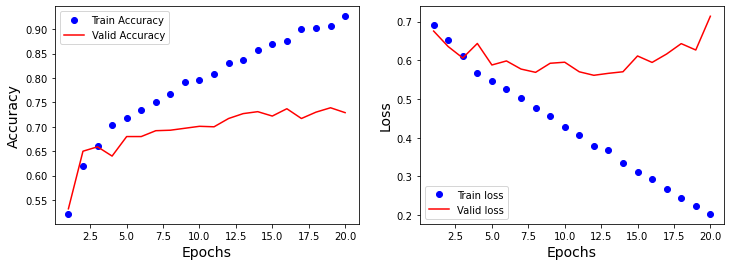

In [9]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = 20
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [10]:
## Evaluate on test_set
loss_test, acc_test = model.evaluate(test_gen)
print('loss_test =>', loss_test)
print('acc_test =>', acc_test)     

50/50 [==============================] - 3s 55ms/step - loss: 0.7047 - accuracy: 0.7120 0s - loss: 0.7047 - accuracy: 0.71
loss_test => 0.7046816349029541
acc_test => 0.7120000123977661


### With Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## augmenation with some variance
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

## create the generators
train_gen = train_datagen.flow_from_directory(directory=train_dir, 
                                              target_size=(150, 150), class_mode='binary', 
                                              color_mode='rgb',  batch_size=20,
                                              shuffle=True)

valid_gen = test_datagen.flow_from_directory(directory=valid_dir, 
                                              target_size=(150, 150), class_mode='binary', 
                                              color_mode='rgb',  batch_size=20,
                                              shuffle=False)

test_gen = test_datagen.flow_from_directory(directory=test_dir, 
                                              target_size=(150, 150), class_mode='binary',
                                              color_mode='rgb',  batch_size=20,
                                              shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


shape of Image before editing  (150, 150, 3)
shape of Image after editing  (1, 150, 150, 3)


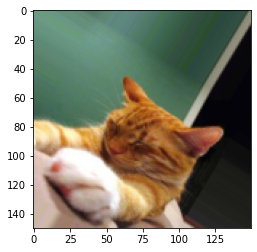

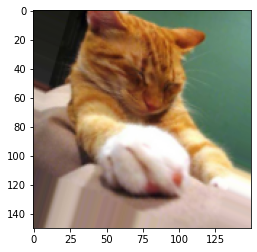

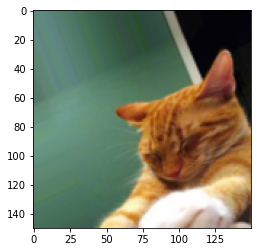

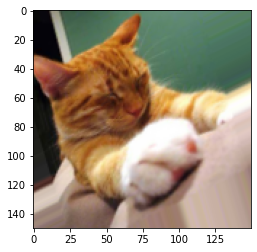

In [12]:
### show some variation that Augmenation makes
from tensorflow.keras.preprocessing import image

cat_img = Image.open(train_cats_paths[50])
cat_img = cat_img.resize((150, 150))  ## to be as taregt

cat_img = np.array(cat_img)
print('shape of Image before editing ', cat_img.shape)  ## we want to add dimension for batch

cat_img = cat_img[np.newaxis, ...]
print('shape of Image after editing ', cat_img.shape)

i = 0
for batch in train_datagen.flow(cat_img, batch_size=1):
    plt.figure(i)
    plt.imshow(batch[0])
    i += 1
    if i % 4 ==0:
        break       ## generator you must break

In [16]:
## model
model = tf.keras.models.Sequential([
    ## conv base
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    ## top classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
          ])

    
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])  
early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_gen, validation_data=valid_gen, 
                    steps_per_epoch=100, validation_steps=50, epochs=30)
   
## steps_per_epoch ---> here you make augmenation you can increse it more than 100 but not too much
## validation_steps=valid_size/batch_size

Epoch 1/30
100/100 [==============================] - 20s 193ms/step - loss: 1.3837 - accuracy: 0.5055 - val_loss: 1.1826 - val_accuracy: 0.5060
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 1.0407 - accuracy: 0.5300 - val_loss: 0.9144 - val_accuracy: 0.5930
Epoch 3/30
100/100 [==============================] - 19s 187ms/step - loss: 0.8735 - accuracy: 0.5590 - val_loss: 0.8325 - val_accuracy: 0.5620
Epoch 4/30
100/100 [==============================] - 17s 173ms/step - loss: 0.7971 - accuracy: 0.6015 - val_loss: 0.7650 - val_accuracy: 0.6130
Epoch 5/30
100/100 [==============================] - 18s 178ms/step - loss: 0.7555 - accuracy: 0.6270 - val_loss: 0.7170 - val_accuracy: 0.6740
Epoch 6/30
100/100 [==============================] - 20s 198ms/step - loss: 0.7245 - accuracy: 0.6440 - val_loss: 0.6947 - val_accuracy: 0.6630
Epoch 7/30
100/100 [==============================] - 21s 212ms/step - loss: 0.7110 - accuracy: 0.6385 - val_loss: 0.6785 - val_ac

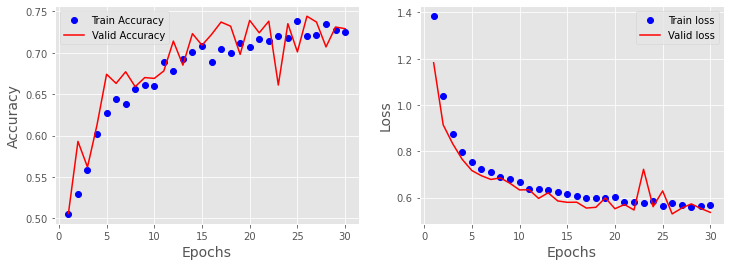

In [17]:
## Visualize the resutls
n_epochs = len(history.history['accuracy'])

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [18]:
## Evaluate on test_set
loss_test, acc_test = model.evaluate(test_gen)
print('loss_test =>', loss_test)
print('acc_test =>', acc_test)     

50/50 [==============================] - 3s 53ms/step - loss: 0.5774 - accuracy: 0.7090
loss_test => 0.5773520469665527
acc_test => 0.7089999914169312


### Done!